# Chapter 8 - Example: Land Data
### Changes in vegetation index through the years for a given area

In this chapter we don't use data from the cloud, but exemplify how to obtain timeseries data from the initernet and analyze. In hte future (hopefully soon), when data is in the cloud on a similar data format, accessing from the cloud would be similar as in chapter 6.

This script reads NDVI (vegetation index) files from a `thredds` server, compile the region and time selected and then analyze the change in vegetation index through time.

In [12]:
# Import libraries
import numpy as np
import pandas as pd
import xarray as xr
import os
import re
from datetime import date
import urllib as ur
import requests
import matplotlib.pyplot as plt 
import hvplot.pandas
import hvplot.xarray
xr.set_options(display_style="html")  #display dataset nicely

# this library helps to make your code execution less messy
import warnings
warnings.simplefilter('ignore') # filter some warning messages

In [3]:
# Set parameters
# Select a region 
lat1, lat2 = 16, 18 # two latitudes, resolution?
lon1, lon2 = -98,-96
# select a day of year. the script will obtain data for the region for this day each available year
mon = 7 # month
dy = 31 # day

***
## Obtaining the data

In [4]:
# find data for chosen day for each year 
ayrs = [*range(1989,date.today().year)] # data available since 1989. for now it is hard coded
iurl = 'https://www.ncei.noaa.gov/thredds/fileServer/' # server link
flist = list() # initialization of file list 
tdt = list() # initialize a list for time

# looks for the file for each year
for i in ayrs:
    r = requests.get('https://www.ncei.noaa.gov/thredds/catalog/cdr/ndvi/files/'+str(i)+'/catalog.html')   # request download the indicated file
    x = re.split("\'",r.text) # search for symbol ' and separate the data (which comes in a html format)
    for j in x: # for each year
        dtnm = '_'+str(i)+str(mon).zfill(2)+str(dy).zfill(2)+'_' # constuct the file name
        if (dtnm in j) & ("catalog.html?" in j): # and if not repeated or a information line
            flist.append(j) # add the file name to our list

In [5]:
# download each file and select region and time
for iy, i in enumerate(flist): 
    iurl2 = iurl + re.split('=',i)[1] # construct the url for each fille
    print(iy,i) # print the file name, just for information
    tmp = ur.request.urlretrieve(iurl2, 'tmp.nc') # this is a different request (no s at the end), download a file that has a specific (non-text) format, saves it in a file call tmp.nc
    nvi = xr.open_dataset('tmp.nc') # now we can use it as regular local files
    nvi.close()
    tdt.append(nvi.time.data[0]) # add the date to oourr liest
    tmp1 = nvi.NDVI[0,:,:].sel(latitude=slice(lat2,lat1),longitude=slice(lon1,lon2)) # select region from the file data
    if iy==0: # if the first year, create an array to sttore data
        nvi_dt = np.full((len(flist),tmp1.shape[0],tmp1.shape[1]), np.nan)
    nvi_dt[iy,:,:] = tmp1.data # store selected data
    os.remove('tmp.nc') # delete file, so we can keep downloading using this name.

0 catalog.html?dataset=cdr/ndvi/files/1989/AVHRR-Land_v005_AVH13C1_NOAA-11_19890731_c20170614183726.nc
1 catalog.html?dataset=cdr/ndvi/files/1990/AVHRR-Land_v005_AVH13C1_NOAA-11_19900731_c20170615072719.nc
2 catalog.html?dataset=cdr/ndvi/files/1991/AVHRR-Land_v005_AVH13C1_NOAA-11_19910731_c20170615200647.nc
3 catalog.html?dataset=cdr/ndvi/files/1992/AVHRR-Land_v005_AVH13C1_NOAA-11_19920731_c20170616081958.nc
4 catalog.html?dataset=cdr/ndvi/files/1993/AVHRR-Land_v005_AVH13C1_NOAA-11_19930731_c20170616193655.nc
5 catalog.html?dataset=cdr/ndvi/files/1994/AVHRR-Land_v005_AVH13C1_NOAA-11_19940731_c20170617070722.nc
6 catalog.html?dataset=cdr/ndvi/files/1995/AVHRR-Land_v005_AVH13C1_NOAA-14_19950731_c20170618010309.nc
7 catalog.html?dataset=cdr/ndvi/files/1996/AVHRR-Land_v005_AVH13C1_NOAA-14_19960731_c20170618114447.nc
8 catalog.html?dataset=cdr/ndvi/files/1997/AVHRR-Land_v005_AVH13C1_NOAA-14_19970731_c20170619003041.nc
9 catalog.html?dataset=cdr/ndvi/files/1998/AVHRR-Land_v005_AVH13C1_NOAA-1

In [14]:
# create a xarray Data array structure for easy analysis from the data above
ndvi = xr.DataArray(data=nvi_dt, dims=['time','latitude','longitude'], 
                    coords=dict(time=tdt,latitude=tmp1.latitude.values, longitude=tmp1.longitude.values),attrs=tmp1.attrs) 
ndvi # taking a peek

<xarray.DataArray (time: 32, latitude: 40, longitude: 40)>
array([[[ 0.25439999,  0.25439999,  0.25439999, ...,  0.59389997,
          0.58069998,  0.56839997],
        [ 0.26179999,  0.26179999,  0.26179999, ...,  0.53639996,
          0.53639996,  0.57809997],
        [ 0.3527    ,  0.3504    ,  0.3504    , ...,  0.433     ,
          0.433     ,  0.47829998],
        ...,
        [ 0.5654    ,  0.5654    ,  0.42679998, ..., -0.0102    ,
          0.015     ,  0.015     ],
        [        nan,         nan,         nan, ...,  0.0448    ,
          0.0152    , -0.0131    ],
        [        nan,         nan,         nan, ...,  0.108     ,
          0.10969999,  0.11279999]],

       [[ 0.1021    ,  0.1021    ,  0.13059999, ...,  0.65249997,
          0.71700001,  0.68919998],
        [ 0.10309999,  0.10309999,  0.0997    , ...,  0.46739998,
          0.67119998,  0.67119998],
        [ 0.0724    ,  0.0724    ,  0.0854    , ...,  0.50819999,
          0.70899999,  0.70899999],
...
        [ 0.5442    ,  0.59709996,  0.59289998, ...,  0.5898    ,
          0.67159998,  0.7184    ],
        [        nan,         nan,  0.62909997, ...,  0.58559996,
          0.62479997,  0.65429997],
        [        nan,         nan,  0.52649999, ...,  0.57660002,
          0.67289996,  0.67210001]],

       [[ 0.1349    ,  0.1056    ,  0.0862    , ..., -0.0796    ,
         -0.0845    , -0.0507    ],
        [ 0.22389999,  0.1107    ,  0.1744    , ..., -0.0116    ,
         -0.0466    ,  0.0014    ],
        [        nan,  0.16839999,  0.2164    , ...,  0.0207    ,
          0.0755    ,  0.0807    ],
        ...,
        [ 0.0488    ,  0.        ,  0.        , ..., -0.0424    ,
         -0.0299    ,  0.0538    ],
        [        nan,  0.        ,  0.0145    , ...,  0.52319998,
          0.26209998,  0.0941    ],
        [        nan,         nan,  0.        , ...,         nan,
                 nan,  0.33359998]]])
Coordinates:
  * time       (time) datetime64[ns] 1989-07-31 1989-07-31 ... 2019-07-31
  * latitude   (latitude) float32 17.974998 17.924995 ... 16.074997 16.024994
  * longitude  (longitude) float32 -97.975 -97.924995 ... -96.075 -96.024994
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

***
## Now, let's do some analysis

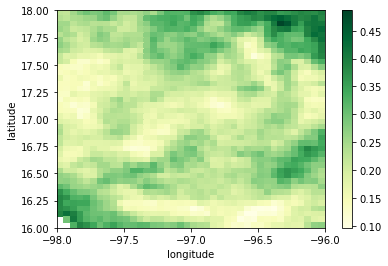

In [7]:
mean_ndvi = ndvi.mean(axis=0)
mean_ndvi.plot(cmap='YlGn')

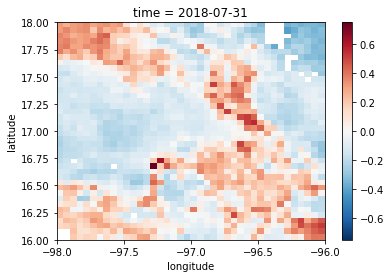

In [8]:
(ndvi.sel(time='2018-'+str(mon).zfill(2)+'-'+str(dy).zfill(2))-mean_ndvi).plot()

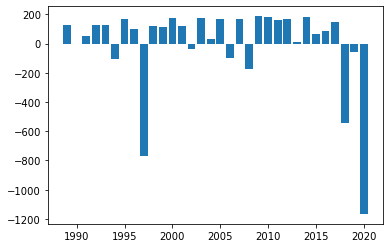

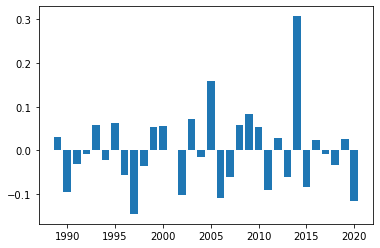

In [9]:
veg_area = list()
veg_mean = list()
for i in range(len(ayrs)): 
    tmp=ndvi[i,:,:].where(ndvi[i,:,:]>=0.03)
    veg_area.append(tmp.count())
    veg_mean.append(tmp.mean())
plt.bar(ayrs,veg_area-np.nanmean(veg_area))
plt.show()
plt.bar(ayrs,veg_mean-np.nanmean(veg_mean))
plt.show()

In [10]:
# another example

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, nv: 2, time: 1700)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2021-08-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2021-09-12 09:48:09 by SBBX_to_nc 2.0 - ILAND=250, ...

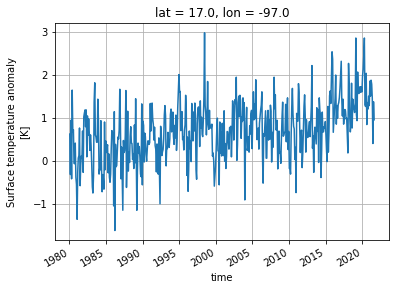

In [11]:
iurl = 'https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz'
#r = requests.get(iurl)
with open('gistmep.nc.gz', "wb") as f:
    r = requests.get(iurl)
    f.write(r.content)
f.close()
os.system('gunzip gistmep.nc.gz')
tas = xr.open_dataset('gistmep.nc')
tas.tempanomaly.sel(lat=17,lon=-97,time=slice('1980-01-01','2021-08-15')).plot()
plt.grid()
tas